In [16]:
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

epochs = 100
learning_rate = 5e-3
batch_size = 128
n_components = 5  # the number of kernel
target_distribution = Normal(0.0, 1.0)


####################################
# STEP 1: Implement 1-d Flow model #
# Model is mixture of Gaussian CDFs #
####################################

class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True)

    def forward(self, x):
        x = x.view(-1, 1)
        weights = self.weight_logits.exp()
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = ( (distribution.cdf(x)-0.5) * weights).sum(dim=1)
        dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1)
        return z, dz_by_dx


################################################
# STEP 2: Create Dataset and Create Dataloader #
################################################

def mixture_of_gaussians(num, mu_var=(-1, 0.25, 0.2, 0.25, 1.5, 0.25)):
    n = num // 3
    m1, s1, m2, s2, m3, s3 = mu_var
    gaussian1 = np.random.normal(loc=m1, scale=s1, size=(n,))
    gaussian2 = np.random.normal(loc=m2, scale=s2, size=(n,))
    gaussian3 = np.random.normal(loc=m3, scale=s3, size=(num - n,))
    return np.concatenate([gaussian1, gaussian2, gaussian3])


class MyDataset(data.Dataset):
    def __init__(self, array):
        super().__init__()
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        return self.array[index]


################################
# STEP 3: Define Loss Function #
################################
def loss_function(target_distribution, z, dz_by_dx):
    # log(p_Z(z)) = target_distribution.log_prob(z)
    # log(dz/dx) = dz_by_dx.log() (flow is defined so that dz/dx>0)
    log_likelihood = target_distribution.log_prob(z) + dz_by_dx.log()
    return -log_likelihood.mean()  # flip sign, and sum of data X_1,...X_N


###########################
# STEP 4: Train the model #
###########################

# create dataloader
n_train, n_test = 5000, 1000
train_data = mixture_of_gaussians(n_train)
test_data = mixture_of_gaussians(n_test)

train_loader = data.DataLoader(MyDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(MyDataset(test_data), batch_size=batch_size, shuffle=True)

# create model
flow = Flow1d(n_components)
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

train_losses, test_losses = [], []

for epoch in range(epochs):
    # train
    flow.train()
    mean_loss = 0
    for i, x in enumerate(train_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss += loss.item()
    train_losses.append(mean_loss / (i + 1))

    # test
    flow.eval()
    mean_loss = 0
    for i, x in enumerate(test_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)

        mean_loss += loss.item()
    test_losses.append(mean_loss / (i + 1))


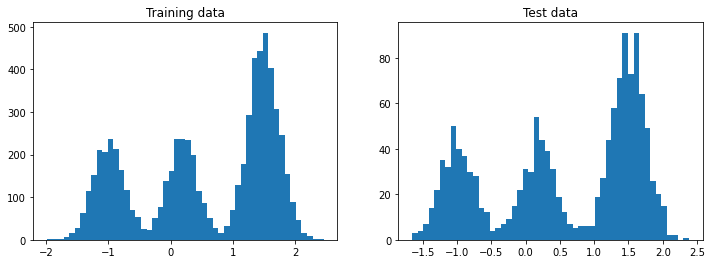

In [17]:
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[0].set_title('Training data')
_ = axes[1].set_title('Test data')

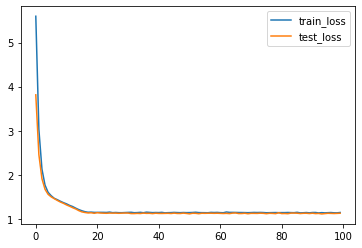

In [18]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()

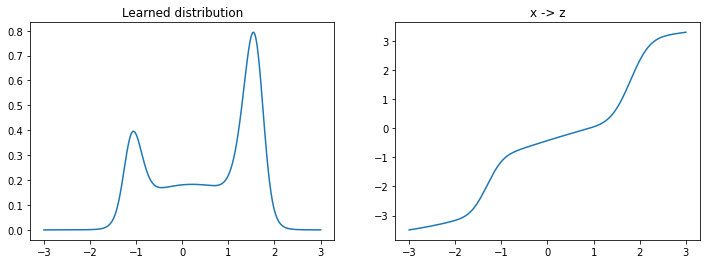

In [19]:
x = np.linspace(-3,3,1000)
with torch.no_grad():
    z, dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().cpu().numpy()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

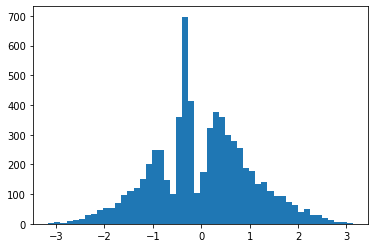

In [20]:
with torch.no_grad():
    z, _ = flow(torch.FloatTensor(train_loader.dataset.array))
    
_ = plt.hist(np.array(z), bins=50)